<a href="https://colab.research.google.com/github/tiasondjaja/circular_societies/blob/master/piercing_number_probabilities-Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approval Voting in Circular Societies:  Piercing Numbers and Agreement
*Kristen Mazur, Mutiara Sondjaja, Matthew Wright, and Carolyn Yarnall*

This Jupyter Notebook is a companion to the paper [title + link goes here].  [Some more blurb]

## 1. How to use this document
+ First, run the code cell in the "Setup" section below.  Do not modify anything.  This code cell must be run at the start of each session.
+ Run the code cells in the remaining sections

For the interested readers, [the code documentation is linked here](https://github.com/tiasondjaja/circular_societies/blob/master/DOCUMENTATION.md).

## 2. Setup

Run the code cell in the "Setup" section below once each time the notebook is started. Do not modify anything.

In [ ]:
import numpy as np
import scipy as sp
import cvxpy as cp
import matplotlib.pyplot as plt
import itertools

# Part 0 ----------------------------------
# Define the Set class (approval set)
class Set:
    # Initialize Class
    def __init__( self, name, left_endpt, right_endpt, modulo ):
        self.name = name
        self.left_endpt = left_endpt
        self.right_endpt = right_endpt
        self.modulo = modulo
    
    # Method to print set name and left- and right-endpoints
    def printSetInfo( self ):
        if self.left_endpt <= self.right_endpt:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.right_endpt) + "]")
        elif self.right_endpt == 0:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
        else:
            print( " " + self.name + ": [0," + str(self.right_endpt) + "] U [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
    
    def editSet( self, newname, newleft_endpt, newright_endpt, newmodulo ):
        self.name = newname
        self.left_endpt = newleft_endpt
        self.right_endpt = newright_endpt
        self.modulo = newmodulo
        
    def isPointInSet( self, point):
        check = False
        
        if (self.left_endpt <= point and point <= self.right_endpt):
             check = True
        elif (self.left_endpt <= point and self.right_endpt <= self.left_endpt):
             check = True
        elif (point <= self.right_endpt and self.right_endpt <= self.left_endpt):
             check = True
            
        return check
  
# Part 1 - MAIN ----------------------------------  

# Define the CircularSociety class

class CircularSociety:
    
    # Initialize Class
    def __init__( self, name, modulo, isUniform = 0, tick = 0.5 ):
        self.name = name
        self.modulo = modulo # modulo > 0; the circular society is represented as [0, modulo) with 0 = modulo
        self.approvalSets = [] # initialize with empty approval sets
        self.numVoters = 0
        self.tick = tick
        
        # List of all endpoints and setnames (useful when checking for left-right alternation)
        self.list_setnames = []
        self.list_left_endpts = []
        self.list_right_endpts = []
    
    # method that returns a set given its name
    def getSet( self, setname ):
      for A in self.approvalSets:
        if A.name == setname:
          return A
      return None
    
    ### DISPLAYING / OBTAINING BASIC INFORMATION ABOUT THE CIRCULAR SOCIETY----
    
    # Method to print list of approval sets
    def listApprovalSets( self ):
        for A in self.approvalSets:
            A.printSetInfo()
            
    # Method to print society information
    def printSocietyInfo( self ):
        print("Circular Society Name: " + self.name)
        print("Spectrum: [0, " + str(self.modulo) + "].  (Note: we identify 0 = " + str(self.modulo) + ")"  )
        print("Number of Voters: " + str(self.numVoters) )
        print("Approval Sets:")
        self.listApprovalSets()
    
    # Method to list the endpoints of the sets, from 0 to N
    def listSetEndpoints( self ):
        N = self.numVoters
        orderedendpts = []
        orderednames = []
        setindices_ordered_left = np.argsort(self.list_left_endpts)
        setindices_ordered_right = np.argsort(self.list_right_endpts)
        left_i = 0
        right_i = 0
        
        for step in range( 0, 2*N ):
            if left_i < N and right_i < N:
                if self.list_left_endpts[ setindices_ordered_left[left_i] ] < self.list_right_endpts[ setindices_ordered_right[right_i] ]:
                    orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                    orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                    left_i += 1
                else:
                    orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                    orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                    right_i += 1
            elif left_i == N and right_i < N:
                orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                right_i += 1
            else:
                orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                left_i += 1
        return orderednames, orderedendpts
      
    
    ### FINDING, EDITING, ADDING, REMOVING APPROVAL SETS-----------------------
    
    # Method to find an approval set by name
    def findApprovalSetName( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                return ind # if set name found, return index
        return -1 # if set name not found, return -1 
    
    # Method to add a new approval set into the society
    def addApprovalSet( self, setName, left_endpt, right_endpt ):
        # Check that setName is different from names of sets already on the list
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        if ind == -1:
            newSet = Set( setName, left_endpt, right_endpt, self.modulo )
            
            # Update attributes
            self.approvalSets.append( newSet )
            self.numVoters += 1
            
            # Update list of all endpoints
            self.list_setnames.append( setName )
            self.list_left_endpts.append( left_endpt )
            self.list_right_endpts.append( right_endpt )
            
        else:
            print("Set is not added because this set name has already been chosen.  Please pick a different set name.")

    # Method to remove an approval set from the society
    def removeApprovalSet( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                self.approvalSets.pop(ind)
                self.list_setnames.pop(ind)
                self.list_left_endpts.pop(ind)
                self.list_right_endpts.pop(ind)
                self.numVoters -= 1
    
    # Method to edit the endpoints of an approval set
    def editApprovalSet( self, setName, newleft_endpt, newright_endpt ):
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        
        if ind == -1:
            print("Set name is not found")
        else:
            A = self.approvalSets[ind]
            A.editSet( setName, newleft_endpt, newright_endpt, self.modulo )
            self.list_left_endpts[ind] = newleft_endpt
            self.list_right_endpts[ind] = newright_endpt
    
    
    ### AGREEABILITY, AGREEMENT NUMBER, PIERCING NUMBER -----------------------
    
    # Method to check (k, m) agreeability (brute force)
    def checkAgreeability( self, k, m):
      setNames = [ A.name for A in self.approvalSets ]
      subcollections_m = [list(i) for i in itertools.combinations(setNames, m)]
      good = [] # is the society k,m agreeable? will store 1 or 0 for each collection of m sets
      bad_m_sets = []
      for collection in subcollections_m:
        good_m_sets = [] # will store 1 or 0 for each collection of k sets
        subcollections_k = [list(i) for i in itertools.combinations(collection, k)]
        for collection1 in subcollections_k:
          setname = collection1[0]
          A = self.getSet(setname)
          left = A.left_endpt
          left_list = np.array([self.getSet(setname1).isPointInSet(left) for setname1 in collection1 ])
          left_good = np.prod(left_list)
          right = A.right_endpt
          right_list = np.array([self.getSet(setname1).isPointInSet(right) for setname1 in collection1 ])
          right_good = np.prod(right_list)
          set_good = 1 - ( (1-left_good) * (1-right_good) ) # good if at least one is good
          good_m_sets.append(set_good)
        good_m_sets = np.array(good_m_sets)
        good_m = 1 - np.prod(1-good_m_sets) # good if at least one is good
        if good_m == 0:
          bad_m_sets.append(collection)
        good.append(good_m)
      good = np.array(good)
      is_kmagreeable = np.prod(good) # good if all is good
      return is_kmagreeable, bad_m_sets
    
    # Method to the find agreement number (and the location)
    def findAgreementNumber( self ):
        Names, Endpts = self.listSetEndpoints()
        agreement = 0
        agrement_location = Endpts[0]
        
        # At each point, the number of intersecting sets changes only when an endpoint is encountered,
        #  therefore, we will check the number of intersecting sets only at endpoints
        for i in Endpts:
          numSets_contain_i = 0
          
          for A in self.approvalSets:
            if A.isPointInSet( i ):
              numSets_contain_i = numSets_contain_i + 1
          
          if numSets_contain_i > agreement:
            agreement = numSets_contain_i
            agreement_location = i
          
        return agreement, agreement_location
      
    def findPiercingNumber( self ):
      # Finding piercing number using an integer linear program (ILP) formulation
      # (a linear program (LP) that is constrained to have integer solutions)
      
      # First, find constraint matrix/data for LP used to find piercing number
      # Candidate piercing points are the endpoints of the intervals
      _, orderedendpts = self.listSetEndpoints()
      N = self.numVoters
      M = 2*N
      Mat = np.empty( [ N, M] )
      for i in np.arange(0, N):
        for j, p in enumerate(orderedendpts):
          A = self.approvalSets[i]
          Mat[i, j] = A.isPointInSet( p )
      
      # Next, vector of coefficients of objective function
      c = np.ones(M)
      
      ## Solve ILP using cvxpy
      x = cp.Variable(M, integer = True)
      objective = cp.Minimize( cp.matmul(c, x) )
      constraints = [ cp.matmul(Mat,x) >= np.ones(N), 0 <= x, x <= 1]
      prob = cp.Problem( objective, constraints )
      val = prob.solve(solver='GLPK_MI')
      piercingNumber = int(np.round(val))
      piercingSet = np.transpose(orderedendpts)[ np.round(x.value) > 0]
      
      return piercingNumber, piercingSet, x.value, Mat
    
    # implementing the linear society piercing number algorithm
    def piercingAlgorithm( self, startingPoint = 0 ):

      orderedendptnames, orderedendpts = self.listSetEndpoints()

      if startingPoint > 0 :
        temp1 = [ x for x in orderedendpts if x >= startingPoint ]
        temp1names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] >= startingPoint]
        temp2 = [x for x in orderedendpts if x < startingPoint]
        temp2names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] < startingPoint]
        orderedendpts = temp1 + temp2
        orderedendptnames = temp1names + temp2names

      uncovered_setnames = []
      N = self.numVoters
      for i in range(0, 2*N):
        if( orderedendptnames[i][0] == "R" ):
          uncovered_setnames.append( orderedendptnames[i][1:] )

      # currently, uncovered_setnames contains all sets' names
      piercingSet = []
      while( len(uncovered_setnames) > 0): #while there are uncovered sets
        current_point = self.getSet(uncovered_setnames[0]).right_endpt
        covered_setnames = [setname for setname in uncovered_setnames if self.getSet(setname).isPointInSet(current_point) ]
        uncovered_setnames = [setname for setname in uncovered_setnames if not self.getSet(setname).isPointInSet(current_point) ]
        piercingSet.append( [current_point, covered_setnames] )
      return piercingSet


    ### HARDIN'S TRANSFORMATIONS (ELIMINATE CONTAINMENT, LR-ALTERNATION)-------
    
    # Method to check if Left-Right-alternating
    def is_LR_alt( self, findRRL = False ):
        L = self.listSetEndpoints()
        numEndpts = len(L[0])
        
        # determine if LR alternating; if findRRL is True, also find names of sets where of RRL endpoints occur
        isLR = True
        RRLsets = list()
        for i in range(0, numEndpts):
            # determine if LR alternating
            if L[0][i][0] == L[0][(i+1)%numEndpts][0]:
                isLR = False
            # find names of sets where of RRL endpoints occur
            if ( findRRL ):
                if(L[0][i%numEndpts][0] == "R" and L[0][(i+1)%numEndpts][0] == "R" and L[0][(i+2)%numEndpts][0] == "L"):
                    RRLsets.append( [ L[0][i%numEndpts][1:], L[0][(i+1)%numEndpts][1:], L[0][(i+2)%numEndpts][1:] ])
        
        if findRRL:
          return isLR, RRLsets
        else:
          return isLR
        
    # Method to check if a pair of sets has containment 
    def checkContainmentPair( self, setPair ):
      Set1Name = setPair[0]
      Set2Name = setPair[1]
      indSet1 = self.findApprovalSetName( Set1Name )
      indSet2 = self.findApprovalSetName( Set2Name )
      containmentIsFound = False
      
      if (indSet1 == -1 or indSet2 == -1):
        print("At least one of the set names is not found")
      else:
        A1 = self.approvalSets[indSet1]
        A2 = self.approvalSets[indSet2]
        
        if( A1.left_endpt <= A1.right_endpt and A2.left_endpt <= A2.right_endpt): 
          # Case 1: A1, A2 both don't wrap around
          if( A1.left_endpt <= A2.left_endpt and A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A2.left_endpt <= A1.left_endpt and A1.right_endpt <= A2.right_endpt ):
            containmentIsFound = True # A1 is contained in A2
          
        elif ( A1.left_endpt <= A1.right_endpt and A2.left_endpt > A2.right_endpt ): 
          # Case 2: A1 doesn't wrap, A2 wraps around
          if( A1.right_endpt <= A2.right_endpt or A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True #A1 is contained in A2
            
        elif ( A1.left_endpt > A1.right_endpt and A2.left_endpt <= A2.right_endpt ): 
          # Case 3: A1 wraps, A2 doesn't wrap around
          if( A1.left_endpt <= A2.left_endpt or A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True #A2 is contained in A1
          
        else: 
          # Case 4: A1, A2 both wrap around
          if( A2.right_endpt <= A1.right_endpt and A1.left_endpt <= A2.left_endpt):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A1.right_endpt <= A2.right_endpt and A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True # A1 is contained in A2
            
      return containmentIsFound
    
    # Method to detect any containent and identifying pairs
    def checkContainmentAll( self, findContainmentPairs = False ):
      N = self.numVoters
      approvalSetNames = self.list_setnames
      containmentPairs = []
      containmentIsFound = False
      
      for i in np.arange(0, N):
        setName1 = self.list_setnames[i]
        for j in np.arange(i+1, N):
          setName2 = self.list_setnames[j]
          
          if ( self.checkContainmentPair( [setName1, setName2]) ):
            
            containmentPairs.append( [setName1, setName2] )
            containmentIsFound = True
            
      if findContainmentPairs:
        return containmentIsFound, containmentPairs
      else:
        return containmentIsFound
    
    # Method to eliminate a pair of containment
    def eliminateContainmentPair( self, containmentPair ):
        smallSetName = containmentPair[0]
        largeSetName = containmentPair[1]
        indSmallSet = self.findApprovalSetName( smallSetName )
        indLargeSet = self.findApprovalSetName( largeSetName )
        
        if (indSmallSet == -1 or indLargeSet == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpoints of the two sets
            ASmall = self.approvalSets[indSmallSet]
            ALarge = self.approvalSets[indLargeSet]
            
            small_right_endpt = ASmall.right_endpt
            small_newright_endpt = ALarge.right_endpt
            large_newright_endpt = small_right_endpt
            
            self.editApprovalSet( smallSetName, ASmall.left_endpt, small_newright_endpt )
            self.editApprovalSet( largeSetName, ALarge.left_endpt, large_newright_endpt )

    # Method to eliminate all containments
    def eliminateContainmentAll( self ):
      
      containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True)
      maxIt = 100
      it = 0
      
      while(containmentIsFound and it < maxIt):
        for setPair in containmentPairs:
          self.eliminateContainmentPair( setPair )
        containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True )
        it = it + 1
      
            
    # Method to eliminate a set of RRL endpoints
    def eliminateRRLTriple( self, RRLsets ):
        Set2Name = RRLsets[1] # first set is unchanged
        Set3Name = RRLsets[2]
        indSet2 = self.findApprovalSetName( Set2Name )
        indSet3 = self.findApprovalSetName( Set3Name )
        
        if (indSet2 == -1 or indSet3 == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpt of Set2 and the left endpoint of Set3
            A2 = self.approvalSets[indSet2]
            A3 = self.approvalSets[indSet3]
            
            set2_right_endpt = A2.right_endpt
            set2_newright_endpt = A3.left_endpt
            set3_newleft_endpt = set2_right_endpt
            
            self.editApprovalSet( Set2Name, A2.left_endpt, set2_newright_endpt)
            self.editApprovalSet( Set3Name, set3_newleft_endpt, A3.right_endpt )
    
    # Method to eliminate all RRL (to achieve LR-alternation)
    def eliminateRRLAll( self, maxIt = 10000 ):
        isLR, RRLsets = self.is_LR_alt( findRRL = True )
        
        numIt = 0
        while( not isLR and numIt < maxIt):
          for triple in RRLsets:
            self.eliminateRRLTriple( triple )
          isLR, RRLsets = self.is_LR_alt( findRRL = True )
          numIt = numIt + 1
        
        if ( not isLR ):
          print("Max iteration reached but the society is still not LR-Alternating")

    # Method to transform into a uniform society
    def uniformize( self ):
        self.eliminateContainmentAll()
        self.eliminateRRLAll()
        

        
    ### VISUALIZATION --------------------------------------------------------
    
    # Method to visualize the sets
    def visualize( self, drawAgreement = False, drawPiercing = False ):
        
        ## Set up grid
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        # Major ticks every 1, minor ticks every self.tick (default = 0.5)
        major_ticks = np.arange(0, self.modulo+1, self.modulo * 0.1)
        minor_ticks = np.arange(0, self.modulo+1, self.tick)        
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        #ax.set_yticks(major_ticks)
        #ax.set_yticks(minor_ticks, minor=True)
        # Different thickness settings for the major and minor grids:
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        plt.yticks(np.arange(0, self.numVoters+1, step = 1) )
        
        # Draw the intervals
        for ind, A in enumerate( self.approvalSets ):
            if A.left_endpt <= A.right_endpt:
                x = [A.left_endpt, A.right_endpt]
                y = [ind+1, ind+1]
                plt.plot( x, y, 'ro-')
            else:
                x = [A.left_endpt, self.modulo]
                y = [ind+1, ind+1]
                plt.plot( A.left_endpt, ind+1, 'ro-', self.modulo, ind+1, 'r>-')
                plt.plot( x, y, 'r')
                x = [0, A.right_endpt]
                plt.plot( 0, ind+1, 'r<-', A.right_endpt, ind+1, 'ro-')
                plt.plot( x, y, 'r')
                
        # Draw one of the points that attains agreement number
        if drawAgreement:
            a, pos = self.findAgreementNumber()
            plt.plot( [pos, pos], [0.8, self.numVoters], 'blue' )
        
        # Draw the piercing points
        if drawPiercing:
          piercingNum, piercingSet, _, _ = self.findPiercingNumber()
          for pos in piercingSet:
            plt.plot( [pos, pos], [0, 0.2 + self.numVoters], 'green', linestyle = 'dashed' )

# Part 3 - generating random circular societies ----------------------------------    

# Define function to generate a random fixed-length circular society
def generateRandomFixedLengthSociety( societyname, N, modulo, p, tick = 0.5 ):
    # N is number of voters
    # modulo is the circumference of the circular society
    # p is a fraction between 0 and 1 that controls the length of approval sets
    #    The length of each set is p times modulo
    # tick = 0.5 : controls tick marks in the visualization
    
    CS = CircularSociety( societyname, modulo, tick = tick )
    
    for i in list(range(N)):
      left = np.random.uniform(low=0, high=modulo)
      right = (left + p * modulo) % modulo
      CS.addApprovalSet( "Set " + str(i+1), left , right )
    
    return CS

# extras:
# Define function to generate a circular society with a random approval sets
def generateRandomSociety( societyname, N, modulo, epsilon = 0.5, mode = 1, a = 1, b = 1 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    # N is number of voters
    # mode lets us choose how the approval sets are generated
    #   mode = 1: endpoints are chosen uniformly at random from [0, modulo]
    #   mode = 2: left endpoint is chosen uniformly at random from [0, modulo]; 
    #             set length is from the beta distribution with parameters a, b
    
    CS = CircularSociety( societyname, modulo, tick = epsilon )
    
    for i in list(range(N)):
      if mode == 1:
        left = np.random.uniform(low=0, high=modulo)
        right = np.random.uniform(low=0, high=modulo)
      elif mode == 2:
        left = np.random.uniform(low=0, high=modulo) 
        right = (left + np.random.beta(a, b)* modulo) % modulo
        
      CS.addApprovalSet( "Set " + str(i+1), left , right )
    
    
    return CS
  
# Define function to generate U(N, h) (Hardin's uniform circular society)
def generateUniformCircularSociety( societyname, N, h, epsilon = 0.5 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    
    CS = CircularSociety( societyname, N, tick = epsilon )
    
    for i in list(range(N)):
        CS.addApprovalSet( "Set " + str(i+1), i, round( (i + h - epsilon) % N, 1) )
    return CS

## 3. Piercing Number Probabilities 



In [ ]:
# -----
# function to approximate the probability of various piercing numbers
# arguments:
#   N: number of approval sets
#   p: length of the approval sets
#   nSoc: number of randomly-generated societies
#   maxTau: max piercing number to approximate the probability of
# returns array of probabilites for tau in 1, 2, ..., maxTau
def computePiercingProbabilities(N, p, nSoc, maxTau):

  modulo = 1 # circumference of the circular society platform
  piercingNumList = np.zeros( nSoc )

  # generate random societies
  for i in range(0, nSoc):
    S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )
    piercingNum, _, _, _ = S.findPiercingNumber()
    piercingNumList[i] = piercingNum
  
  # compute probabilities of piercing numbers
  probs = np.zeros(maxTau)
  for i in range(maxTau):
    probs[i] = np.sum( piercingNumList == i+1 )/nSoc

  return probs, piercingNumList

# -----
# function to compute conjectured probability of piercing number equal to k
def probConjecture(n, k, p):
  return sp.special.comb(n, k)*( (1 - k*p)**(k-1) )*( (k*p)**(n-k) )


### 3.1. Simulations

#### 3.1.1. Simple simulations

In [ ]:
# ---
nSoc = 1000 # number of randomly-generated societies
maxTau = 6

N = 6 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.19

simulated_probs, piercingNumList = computePiercingProbabilities(N, p, nSoc, maxTau)

conjectured_probs = np.zeros(maxTau)
for i in range(maxTau):
  conjectured_probs[i] = probConjecture(N, i+1, p)

# print results & stats
print('-----------------------------')
print('Number of approval sets: ', N)
print('Length of each approval sets: ', p)
print('Number of randomly-generated circular societies: ', nSoc)
print('-----------------------------')

# piercing number stats
print('Piercing Numbers - Summary Statistics')
print('Min: ', np.min(piercingNumList))
print('Max: ', np.max(piercingNumList))
print('Mean: ', np.mean(piercingNumList))
print('Median: ', np.median(piercingNumList))
print('Standard deviation: ', np.std(piercingNumList))
print('-----------------------------')

for i in range(0, maxTau):
  print('Fraction with tau = {0} : {1}'.format( i+1, simulated_probs[i]) )
  print('Conjecture says: {0}'.format(conjectured_probs[i] ) )

print('-----------------------------')

-----------------------------
Number of approval sets:  6
Length of each approval sets:  0.19
Number of randomly-generated circular societies:  1000
-----------------------------
Piercing Numbers - Summary Statistics
Min:  1.0
Max:  4.0
Mean:  2.941
Median:  3.0
Mode:  ModeResult(mode=array([3.]), count=array([675]))
Standard deviation:  0.5722927572492945
-----------------------------
Fraction with tau = 1 : 0.002
Conjecture says: 0.0014856594
Fraction with tau = 2 : 0.189
Conjecture says: 0.193917648
Fraction with tau = 3 : 0.675
Conjecture says: 0.684843714
Fraction with tau = 4 : 0.134
Conjecture says: 0.11977113599999997
Fraction with tau = 5 : 0.0
Conjecture says: 3.562500000000013e-05
Fraction with tau = 6 : 0.0
Conjecture says: -5.378240000000024e-05
-----------------------------


#### 3.1.2. Confidence intervals

In [ ]:
# ---
nSamples = 100 # number of times we sample
nSoc = 100 # number of randomly-generated societies, per sample
maxTau = 6 # compute piercing num probability for each k = 1, ..., maxTau

N = 6 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.1

simulated_probs_all = np.zeros( (nSamples, maxTau) )

for s in range(nSamples):
  simulated_probs_all[s, : ], _ = computePiercingProbabilities(N, p, nSoc, maxTau)

conjectured_probs = np.zeros(maxTau)
for i in range(maxTau):
  conjectured_probs[i] = probConjecture(N, i+1, p)

In [ ]:
pmax = 97.5
pmin = 2.5
for i in range( maxTau ):
  print("{2}% CI for the probability that tau = {0} is approximately: {1}".format(i+1, np.percentile(simulated_probs_all[:,i].T, [pmin, pmax]), pmax - pmin))
  print('Conjecture says: {0}'.format(conjectured_probs[i] ) )

95.0% CI for the probability that tau = 1 is approximately: [0. 0.]
Conjecture says: 6.0000000000000015e-05
95.0% CI for the probability that tau = 2 is approximately: [0.   0.04]
Conjecture says: 0.019200000000000002
95.0% CI for the probability that tau = 3 is approximately: [0.1795 0.37  ]
Conjecture says: 0.2646000000000001
95.0% CI for the probability that tau = 4 is approximately: [0.38425 0.6205 ]
Conjecture says: 0.5184
95.0% CI for the probability that tau = 5 is approximately: [0.11 0.28]
Conjecture says: 0.1875
95.0% CI for the probability that tau = 6 is approximately: [0.      0.03525]
Conjecture says: 0.010239999999999989


In [ ]:
# ---
nSamples = 1000 # number of times we sample
nSoc = 100 # number of randomly-generated societies, per sample
maxTau = 6 # compute piercing num probability for each k = 1, ..., maxTau

N = 10 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.1

simulated_probs_all = np.zeros( (nSamples, maxTau) )

for s in range(nSamples):
  simulated_probs_all[s, : ], _ = computePiercingProbabilities(N, p, nSoc, maxTau)

conjectured_probs = np.zeros(maxTau)
for i in range(maxTau):
  conjectured_probs[i] = probConjecture(N, i+1, p)

In [ ]:
pmax = 80
pmin = 20
for i in range( maxTau ):
  print("{2}% CI for the probability that tau = {0} is approximately: {1}".format(i+1, np.percentile(simulated_probs_all[:,i].T, [pmin, pmax]), pmax - pmin))
  print('Conjecture says: {0}'.format(conjectured_probs[i] ) )

60% CI for the probability that tau = 1 is approximately: [0. 0.]
Conjecture says: 1.0000000000000005e-08
60% CI for the probability that tau = 2 is approximately: [0. 0.]
Conjecture says: 9.216000000000005e-05
60% CI for the probability that tau = 3 is approximately: [0.   0.02]
Conjecture says: 0.012859560000000011
60% CI for the probability that tau = 4 is approximately: [0.15 0.22]
Conjecture says: 0.18579456000000003
60% CI for the probability that tau = 5 is approximately: [0.45 0.53]
Conjecture says: 0.4921875
60% CI for the probability that tau = 6 is approximately: [0.24  0.312]
Conjecture says: 0.27869183999999986


### 3.2. Visualizations of conjectured probabilities vs. simulation results for a range of approval set lengths

RESULTS FOR 6 APPROVAL SETS

In [ ]:
numSets = 6
numTau = 6
numProbs = 40
pvals6 = np.linspace(0.01, 0.30, numProbs)
prob6 = np.zeros( (numProbs, numTau) )

for r in range(numProbs):
  prob6[r] = computePiercingProbabilities(numTau, pvals6[r], 1000, numTau)
  print("finished p = "+str(pvals6[r]))

prob6

finished p = 0.01
finished p = 0.017435897435897435
finished p = 0.02487179487179487
finished p = 0.03230769230769231
finished p = 0.03974358974358974
finished p = 0.04717948717948718
finished p = 0.054615384615384614
finished p = 0.062051282051282054
finished p = 0.06948717948717949
finished p = 0.07692307692307691
finished p = 0.08435897435897435
finished p = 0.0917948717948718
finished p = 0.09923076923076922
finished p = 0.10666666666666666
finished p = 0.1141025641025641
finished p = 0.12153846153846153
finished p = 0.12897435897435897
finished p = 0.13641025641025642
finished p = 0.14384615384615385
finished p = 0.1512820512820513
finished p = 0.15871794871794873
finished p = 0.16615384615384615
finished p = 0.1735897435897436
finished p = 0.18102564102564103
finished p = 0.18846153846153846
finished p = 0.1958974358974359
finished p = 0.20333333333333334
finished p = 0.21076923076923076
finished p = 0.21820512820512822
finished p = 0.22564102564102564
finished p = 0.233076923076

array([[0.   , 0.   , 0.   , 0.029, 0.259, 0.712],
       [0.   , 0.   , 0.001, 0.063, 0.372, 0.564],
       [0.   , 0.   , 0.008, 0.121, 0.409, 0.462],
       [0.   , 0.   , 0.015, 0.154, 0.478, 0.353],
       [0.   , 0.002, 0.023, 0.225, 0.485, 0.265],
       [0.   , 0.   , 0.04 , 0.279, 0.5  , 0.181],
       [0.   , 0.002, 0.061, 0.361, 0.44 , 0.136],
       [0.   , 0.002, 0.081, 0.396, 0.437, 0.084],
       [0.   , 0.003, 0.116, 0.462, 0.356, 0.063],
       [0.   , 0.006, 0.156, 0.465, 0.321, 0.052],
       [0.   , 0.012, 0.18 , 0.505, 0.277, 0.026],
       [0.   , 0.013, 0.184, 0.537, 0.249, 0.017],
       [0.   , 0.024, 0.249, 0.512, 0.207, 0.008],
       [0.   , 0.022, 0.323, 0.498, 0.148, 0.009],
       [0.001, 0.025, 0.351, 0.509, 0.11 , 0.004],
       [0.   , 0.042, 0.384, 0.476, 0.094, 0.004],
       [0.   , 0.055, 0.414, 0.48 , 0.051, 0.   ],
       [0.   , 0.063, 0.478, 0.42 , 0.039, 0.   ],
       [0.001, 0.065, 0.492, 0.417, 0.025, 0.   ],
       [0.001, 0.091, 0.558, 0.

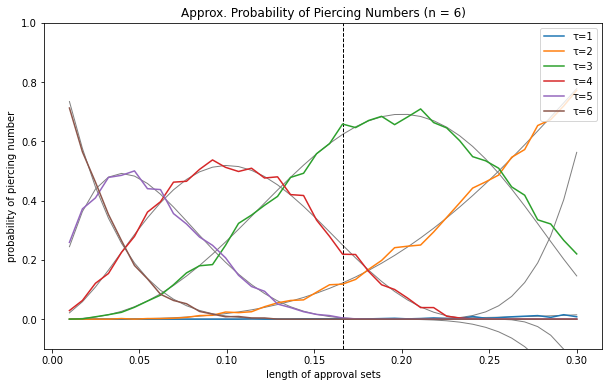

In [ ]:
conjectureVals = np.array([ [probConjecture(numSets, k, p) for k in range(1, numTau+1)] for p in pvals6 ])

plt.figure(figsize=(10,6))
plt.plot(pvals6, prob6, zorder=5)
plt.plot(pvals6, conjectureVals, color="gray", linewidth=1, zorder=1)
plt.axvline(x=1/6, color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Approx. Probability of Piercing Numbers (n = {0})".format(numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["τ="+str(i) for i in range(1,numTau+1)], loc=1);

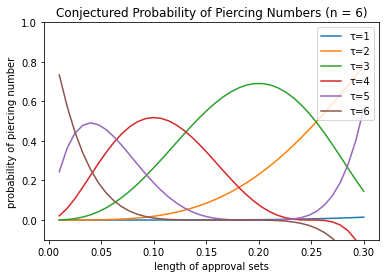

In [ ]:
plt.plot(pvals6, conjectureVals)
plt.ylim((-0.1,1))
plt.title("Conjectured Probability of Piercing Numbers (n = {0})".format(numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["τ="+str(i) for i in range(1,numTau+1)], loc=1);

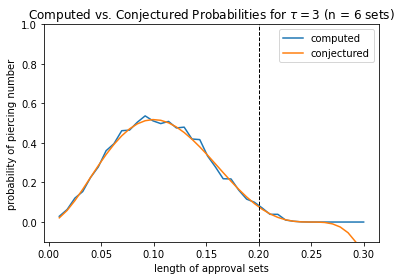

In [ ]:
k=3
plt.plot(pvals6, prob6[:,k])
plt.plot(pvals6, conjectureVals[:,k])
plt.axvline(x=1/(k+2), color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Computed vs. Conjectured Probabilities for $\\tau = {0}$ (n = {1} sets)".format(k, numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["computed","conjectured"]);

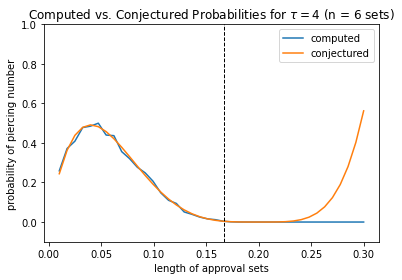

In [ ]:
k=4
plt.plot(pvals6, prob6[:,k])
plt.plot(pvals6, conjectureVals[:,k])
plt.axvline(x=1/(k+2), color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Computed vs. Conjectured Probabilities for $\\tau = {0}$ (n = {1} sets)".format(k, numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["computed","conjectured"]);

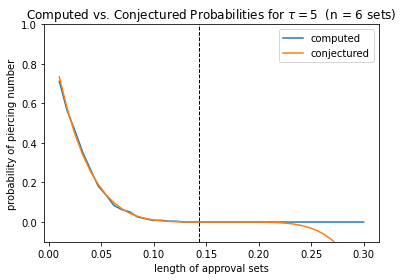

In [ ]:
k=5
plt.plot(pvals6, prob6[:,k])
plt.plot(pvals6, conjectureVals[:,k])
plt.axvline(x=1/(k+2), color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Computed vs. Conjectured Probabilities for $\\tau = {0}$  (n = {1} sets)".format(k, numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["computed","conjectured"]);

RESULTS FOR 10 APPROVAL SETS

In [ ]:
numSets = 10
numTau = 6
numProbs = 40
pvals6 = np.linspace(0.01, 0.30, numProbs)
prob6_100 = np.zeros( (numProbs, numTau) )

for r in range(numProbs):
  prob6_100[r] = computePiercingProbabilities(numSets, pvals6[r], 1000, numTau)
  print("finished p = "+str(pvals6[r]))

prob6_100

finished p = 0.01
finished p = 0.017435897435897435
finished p = 0.02487179487179487
finished p = 0.03230769230769231
finished p = 0.03974358974358974
finished p = 0.04717948717948718
finished p = 0.054615384615384614
finished p = 0.062051282051282054
finished p = 0.06948717948717949
finished p = 0.07692307692307691
finished p = 0.08435897435897435
finished p = 0.0917948717948718
finished p = 0.09923076923076922
finished p = 0.10666666666666666
finished p = 0.1141025641025641
finished p = 0.12153846153846153
finished p = 0.12897435897435897
finished p = 0.13641025641025642
finished p = 0.14384615384615385
finished p = 0.1512820512820513
finished p = 0.15871794871794873
finished p = 0.16615384615384615
finished p = 0.1735897435897436
finished p = 0.18102564102564103
finished p = 0.18846153846153846
finished p = 0.1958974358974359
finished p = 0.20333333333333334
finished p = 0.21076923076923076
finished p = 0.21820512820512822
finished p = 0.22564102564102564
finished p = 0.233076923076

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.001, 0.005],
       [0.   , 0.   , 0.   , 0.   , 0.006, 0.043],
       [0.   , 0.   , 0.   , 0.   , 0.019, 0.111],
       [0.   , 0.   , 0.   , 0.004, 0.027, 0.158],
       [0.   , 0.   , 0.   , 0.001, 0.058, 0.266],
       [0.   , 0.   , 0.   , 0.01 , 0.104, 0.336],
       [0.   , 0.   , 0.   , 0.024, 0.14 , 0.415],
       [0.   , 0.   , 0.004, 0.033, 0.251, 0.404],
       [0.   , 0.   , 0.   , 0.056, 0.314, 0.431],
       [0.   , 0.   , 0.007, 0.095, 0.371, 0.412],
       [0.   , 0.   , 0.004, 0.143, 0.435, 0.339],
       [0.   , 0.   , 0.013, 0.161, 0.51 , 0.296],
       [0.   , 0.   , 0.025, 0.254, 0.506, 0.196],
       [0.   , 0.   , 0.017, 0.311, 0.523, 0.148],
       [0.   , 0.   , 0.036, 0.375, 0.5  , 0.089],
       [0.   , 0.   , 0.052, 0.431, 0.482, 0.035],
       [0.   , 0.   , 0.092, 0.518, 0.37 , 0.02 ],
       [0.   , 0.   , 0.106, 0.585, 0.304, 0.005],
       [0.   , 0.001, 0.15 , 0.

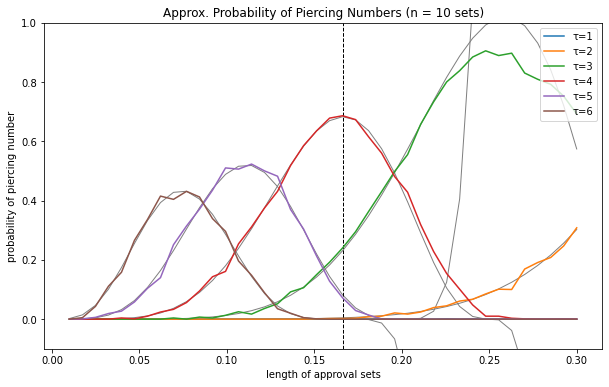

In [ ]:
conjectureVals = np.array([ [probConjecture(numSets, k, p) for k in range(1, numTau+1)] for p in pvals6 ])

plt.figure(figsize=(10,6))
plt.plot(pvals6, prob6_100, zorder=5)
plt.plot(pvals6, conjectureVals, color="gray", linewidth=1, zorder=1)
plt.axvline(x=1/6, color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Approx. Probability of Piercing Numbers (n = {0} sets)".format(numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["τ="+str(i) for i in range(1,numTau+1)], loc=1);

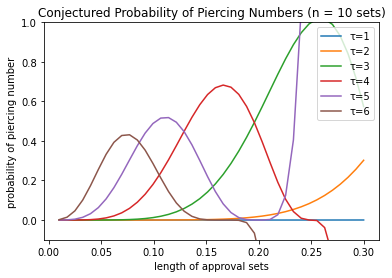

In [ ]:
plt.plot(pvals6, conjectureVals)
plt.ylim((-0.1,1))
plt.title("Conjectured Probability of Piercing Numbers (n = {0} sets)".format(numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["τ="+str(i) for i in range(1,numTau+1)], loc=1);

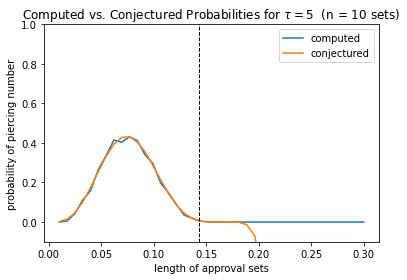

In [ ]:
k=5
plt.plot(pvals6, prob6_100[:,k])
plt.plot(pvals6, conjectureVals[:,k])
plt.axvline(x=1/(k+2), color='k', linestyle='--', linewidth=1)
plt.ylim((-0.1,1))
plt.title("Computed vs. Conjectured Probabilities for $\\tau = {0}$  (n = {1} sets)".format(k, numSets))
plt.xlabel("length of approval sets")
plt.ylabel("probability of piercing number")
plt.legend(["computed","conjectured"]);